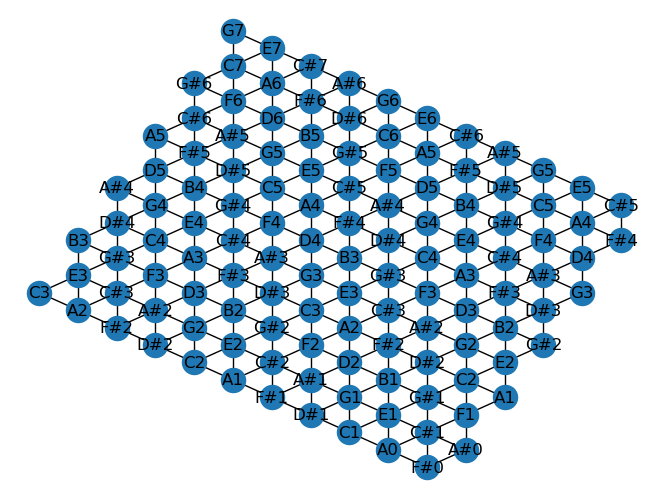

In [5]:
from tonnetz import Tonnetz
t = Tonnetz()
t.draw()

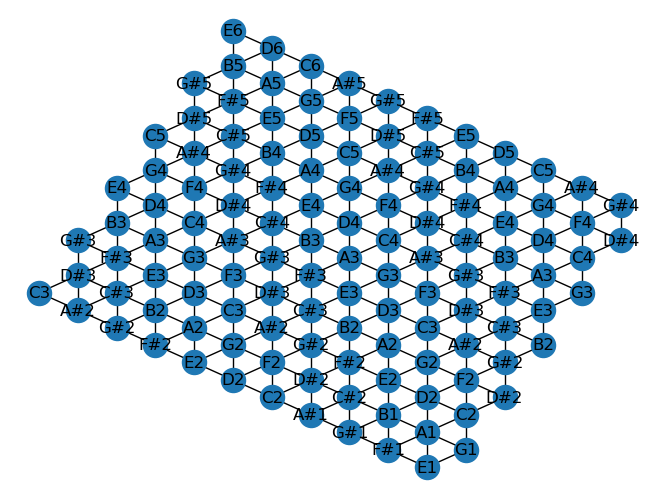

In [6]:
t = Tonnetz((2,3,7))
t.draw()